In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
cand = pd.read_csv('../votacoes/output/candidatos.csv')
votos = pd.read_csv('../votacoes/output/votos.csv')

In [14]:
hist = cand[['ano', 'candidato_id', 'partido']]

(0, 3)

In [23]:
votos['date'] = votos['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
votos['ano'] = votos['date'].apply(lambda x:x.year)

In [68]:
df = pd.merge(hist, votos, on=['candidato_id', 'ano'], how='inner')

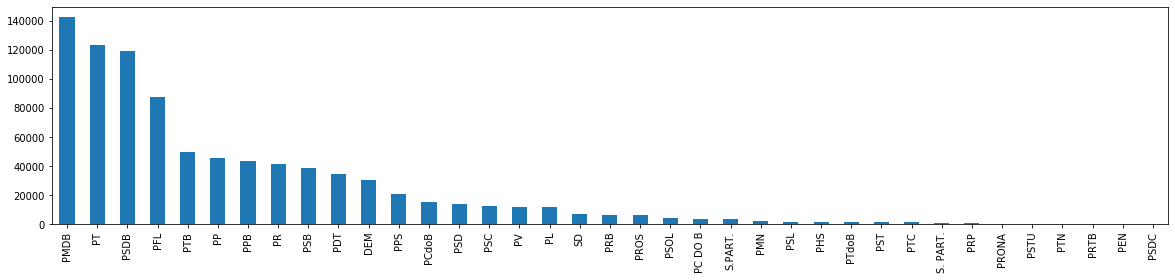

In [69]:
plt.figure(figsize=(20,4))
df['partido'].value_counts().plot(kind="bar")

In [77]:
partido_cont = df['partido'].value_counts()
mfp = partido_cont[partido_cont > 10000].index.values.tolist()
df = df[df['partido'].isin(mfp)]

In [78]:
v = pd.pivot_table(df, values='voto', index=['candidato_id', 'partido'], columns='sessao_id', fill_value=0)

In [79]:
v

sessao_id             01/1991  011/2001  052/1999  071/98  08/99  09/99  \
candidato_id partido                                                      
3151         DEM            0         0         0       0   0.00    0.0   
3155         DEM            0         0         0       0   0.00    0.0   
4927         DEM            0         0         0       0   0.00    0.0   
4929         PSB            0         0         0       0   0.00    0.0   
             PT             0         0         0       0   0.00    0.0   
4930         PSC            0         0         0       0   0.00    0.0   
             PTB            0         0         0       0   0.00    0.0   
4931         PSDB           0         0         0       0   0.00    0.0   
62881        PMDB           0         0         0       0   0.00    0.0   
62926        PTB            0         0         0       0   0.00    0.0   
64224        PFL            0         0         0       0   0.00    0.0   
64960        PSB            0         0         0       0   0.00    0.0   
65498        PSDB           1        -1         0       0   0.50    0.0   
65511        PSB            0         0         0       0   0.00    0.0   
65551        PDT            0         0         0       0   0.00    0.0   
65904        PMDB           0        -1         0       0   0.75    0.0   
65987        PMDB           0         0         0       0   0.00    0.0   
66476        PDT            0         0         0       0   0.00    0.0   
66490        PSDB           0         0         0       0   0.00    0.0   
67105        PT             0         0         0      -1   0.00    0.0   
67138        PP             0         0         0       0   0.00    0.0   
67836        PT             0         0         0      -1   0.00    0.0   
68676        PT             0         0         0      -1   0.00    0.0   
72553        PMDB           0         0         0       0   0.00    0.0   
73416        PMDB           0         0         0       0   0.00    0.0   
             PSDB           0         0         0       0   0.00    0.0   
73417        PSDB           0         0         0       0   0.00    0.0   
73418        PMDB           0         0         0      -1   0.00    0.0   
73419        PPB            0         0         0       1   0.00    0.0   
73420        PTB            1         0         0       1   0.75    0.0   
...                       ...       ...       ...     ...    ...    ...   
167617       PT             0         0         0       0   0.00    0.0   
167707       PMDB           0         0         0       0   0.00    0.0   
167722       PDT            0         0         0       0   0.00    0.0   
168034       PSB            0         0         0       0   0.00    0.0   
168447       PMDB           0         0         0       0   0.00    0.0   
169553       PMDB           0         0         0       0   0.00    0.0   
169711       PSDB           0         0         0       0   0.00    0.0   
169712       PSB            0         0         0       0   0.00    0.0   
170489       PDT            0         0         0       0   0.00    0.0   
170673       PSC            0         0         0       0   0.00    0.0   
171617       PT             0         0         0       0   0.00    0.0   
171618       DEM            0         0         0       0   0.00    0.0   
171619       PT             0         0         0       0   0.00    0.0   
171620       PP             0         0         0       0   0.00    0.0   
171621       PV             0         0         0       0   0.00    0.0   
171622       PR             0         0         0       0   0.00    0.0   
171623       PMDB           0         0         0       0   0.00    0.0   
172029       PT             0         0         0       0   0.00    0.0   
172711       PSDB           0         0         0       0   0.00    0.0   
172945       PSC            0         0         0       0   0.00    0.0   
173262       PT          

In [90]:
part = v.reset_index().drop('candidato_id', axis=1).groupby('partido').mean()

In [104]:
a = PIL.Image.open('../logos/PV.png').thumbnail((100, 100))

In [105]:
a

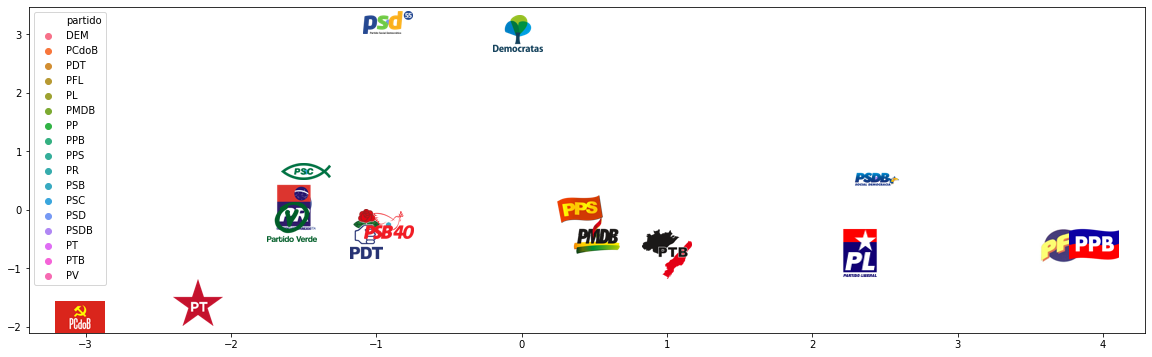

In [118]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import PIL
import glob

x, y = PCA(2).fit_transform(part).T
fig, ax = plt.subplots(figsize=(20, 6))

def getImage(partido):
    p = partido.upper().replace(' ', '')
    path = glob.glob(f"../logos/{p}.*")[0]
    img = PIL.Image.open(path)
    img.thumbnail((50, 50))
    return OffsetImage(img)

sns.scatterplot(x, y, hue=part.index)
for x0, y0, path in zip(x, y, part.index.tolist()):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [81]:
x, y = PCA(2).fit_transform(v).T

plt.figure(figsize=(20,10))
partido = v.index.get_level_values('partido')
sns.scatterplot(x, y, hue=partido)